<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/GoingDeeper/GoingDeeper_NLP2_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: SentencePiece 사용하기

## 1. 필요 모듈 설치

In [1]:
 ! sudo apt-get install g++ openjdk-8-jdk python3-dev python3-pip curl
 ! python3 -m pip install --upgrade pip
 ! python3 -m pip install konlpy
 ! sudo apt-get install curl git
 ! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.20).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
python3-dev is already the newest version (3.6.7-1~18.04).
openjdk-8-jdk is already the newest version (8u342-b07-0ubuntu1~18.04).
python3-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.20).
git is already the newest version 

In [2]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.8.2
1.21.6
0.6.0


In [4]:
! pip install sentencepiece=='0.1.96'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
! pip list | grep sentencepiece

sentencepiece                 0.1.96


## 2. 데이터 불러오기  
이전에 익스노드에서 사용해봤던 네이버 리뷰 데이터를 불러온다.

In [6]:
import pandas as pd

train_data = pd.read_table('/content/drive/MyDrive/Colab/Datasets/ratings/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab/Datasets/ratings/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print('데이터 개수 :', len(train_data))

데이터 개수 : 150000


15만개의 데이터,,

결측치는 제거하자

In [8]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [9]:
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')
print(train_data.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
149995  False     False  False
149996  False     False  False
149997  False     False  False
149998  False     False  False
149999  False     False  False

[149995 rows x 3 columns]>


중복도 제거해주자

In [10]:
cleaned_corpus = train_data.drop_duplicates(['document'])  
test_data = test_data.drop_duplicates(['document'])  

In [11]:
cleaned_corpus.shape

(146182, 3)

14만6천개 데이터가 남는다.  
남은 데이터 중에 문장 길이에 따른 분포를 확인해보자.

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


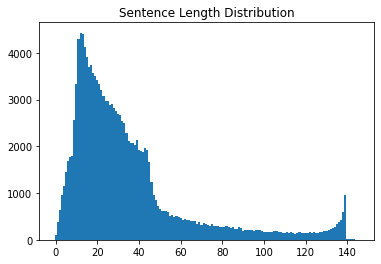

In [12]:
min_len = 999
max_len = 0
sum_len = 0

for row in cleaned_corpus['document']:
    length = len(row)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for row in cleaned_corpus['document']:
    sentence_length[len(row)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

1~146까지 길이가 다양하다.  
문장 길이에 따른 내용을 확인할 수 있는 함수를 만들어서 길이가1 인 데이터를 확인해보자.

In [13]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(cleaned_corpus['document'], 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


대체적으로 쓸모없어보인다.  
1500개 이상의 데이터를 가지는 문장길이를 확인해보자.

In [14]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46


7~46일 때 1500개 이상의 데이터를 가진다.  
다른 문장길이의 데이터도 확인해보자.

In [15]:
check_sentence_with_length(cleaned_corpus['document'], 11)

백봉기 언제나오나요?
아주 모자라진 않다.
공유 존잘!!!ㅎㅎㅎ
4대2라니....최악
내 생의 최고의 영화
이딴게 한국 영화라니
번지수 잃고 갈팡질팡
너무나 감동적인 영화
내 인생 최고의 영화
참 재밌는 영화 ㅎㅎ
2.2고고하자 ㅋㅋㅋ
난 별로던데 -_ -
커스틴 때문에 좋겠다
재미있게봄 감동적이고
딱 90년대코미디영화
이건좀 아니잖아...
최고의 드라마....
야경꾼보다 엉망지루함
딱말해준다잉 안나온다
장선우 여전히 쓰레기
한국영화흥행의 시작점
이런게 영화라는거죠.
억지...억지....
세련되고 재밌었어요.
시대착오적 애니메이션
이건 또 뭔가요;;;
망작 중의 망작...
노답이다 진짜....
무의미한 애니메이션.
거 참 재밌는 영화균
상영관좀 늘려주세요.
픽션이지만 재미뚬ㅎㅎ
한지민은 여신이다..
또 번개냐 ㅋㅋㅋㅋㅋ
뷰우우우우티이이이이풀
막장드라됨급도 안됨.
2탄에 비하면 뭐..
개꿀잼ㅋ개꿀잼ㅋ10자
재밌어요 나름 괜찮음
너무 감동적이에욧><
그지같다고!!!!!!
별로에요 재미없네요호
짜리몽땅 파이팅!!!
구관이 명관이다...
진짜볼만함!!@!@!
하 시방ㅡㅡ:@!?.
이제보니까 장백기였네
쓰레기..10자 채움
하나님살려주시지...
대략 재미 없음...
굿굿 잘봤습니다~~ㅅ
나도 다큐나 찍어볼까
마지막에어이없네왜죽어
아바타같은소리하네..
이건 정말 명작이네요
별덤높이기다디다디도러
재밌다........
쓰레기다 솔직히...
정말 현실성없는 영화
재밌게 잘봣습니다!!
어린아이들만 재미있고
그렇게 대단하지 않다
로코좋아하는분께추천!
린제리 로한 사랑함.
내용을말로표현못하게씀
잼있습니다 야호호호호
정말 훈훈한방송입니다
박준형?이 나온다;;
병만옹 짱짜아악앙맨앤
재미있네요.훌륭합니다
정말 소름끼친다!!!
오겡끼데쓰까 부시맨!
좋다.,/,./,./
말할것도없다 최고ㅇㅇ
일하기싫었나봐여ㅎㅅㅎ
인생을 느끼다....
기억이 가물가물하네요
꿀잼 다시보고싶은영화
표절?표절?표절?표절
이거 우리나라꺼 아님
개연성은 개나 줘버려
엉망진창 로맨틱드라마
가슴이 바운OO운스~
노잼 ㅡ

문장은 7~60의 길이를 가지는 데이터만 사용하도록 하자.

(125612, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


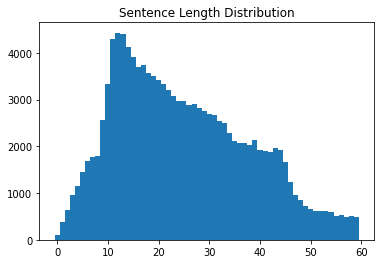

In [16]:
max_len = 60
min_len = 0

train = cleaned_corpus[(cleaned_corpus['document'].str.len() <= max_len) & (cleaned_corpus['document'].str.len() >= min_len)]
test = test_data[(test_data['document'].str.len() <= max_len) & (test_data['document'].str.len() >= min_len)]

print(train.shape)

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()


최종으로 사용할 훈련에 사용할 데이터는 12만8천개이다.  

## 2. SentencePiece Model 학습하기
SentencePiece Model 을 통해 학습해보자.

In [17]:
import sentencepiece as spm
import os
temp_file = '/content/drive/MyDrive/Colab/Datasets/kor_eng_park/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 375037 Sep 27 08:01 korean_spm.model
-rw-r--r-- 1 root root 535555 Sep 27 06:10 korean_spm_unigram_16k.model
-rw-r--r-- 1 root root 311989 Sep 27 06:10 korean_spm_unigram_16k.vocab
-rw-r--r-- 1 root root 144457 Sep 27 08:01 korean_spm.vocab


In [18]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1709, 10, 419, 15, 1379, 10, 152, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


완벽한 구분을 하지는 못하는 것으로 보인다.  
훈련시킨 SentencePiece Model을 토큰화 시켜주는 함수를 만들어보자.

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [19]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [20]:
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[   0    0    0    0  511 3047   14 1255 1808    4]
 [1491 2103  248  519   10    3   17 7915  815    8]]


### 3. LSTM 모델로 학습

In [21]:
tensor_train, word_index, index_word = sp_tokenize(s, train['document'])
tensor_test, word_index, index_word = sp_tokenize(s, test['document'])

In [22]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(train['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor_train, filtered_label, test_size=0.3, random_state=124)
x_test = tensor_test
y_test = test['label']

In [23]:
from tensorflow.keras.initializers import Constant
import keras

vocab_size = vocab_size
word_vector_dim = 64 

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, ))
            
model_LSTM.add(keras.layers.LSTM(20))
model_LSTM.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          512000    
                                                                 
 lstm (LSTM)                 (None, 20)                6800      
                                                                 
 dense (Dense)               (None, 8000)              168000    
                                                                 
 dense_1 (Dense)             (None, 1)                 8001      
                                                                 
Total params: 694,801
Trainable params: 694,801
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    verbose=1)

Epoch 1/5
1374/1374 [==============================] - 10s 6ms/step - loss: 0.4033 - accuracy: 0.8138 - val_loss: 0.3550 - val_accuracy: 0.8419
Epoch 2/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.3079 - accuracy: 0.8644 - val_loss: 0.3419 - val_accuracy: 0.8497
Epoch 3/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.2606 - accuracy: 0.8858 - val_loss: 0.3609 - val_accuracy: 0.8442
Epoch 4/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.2188 - accuracy: 0.9028 - val_loss: 0.3903 - val_accuracy: 0.8410
Epoch 5/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.1779 - accuracy: 0.9229 - val_loss: 0.4855 - val_accuracy: 0.8337


In [25]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)

1320/1320 - 4s - loss: 0.4919 - accuracy: 0.8281 - 4s/epoch - 3ms/step


정확도 82.81% 가 나왔다.

## 4. Sentence Piece 옵션간 성능 비교

In [26]:
temp_file = '/content/drive/MyDrive/Colab/Datasets/kor_eng_park/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in train['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram_16k --vocab_size={}'.format(temp_file, vocab_size*2)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_16k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size*2)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [27]:
def sp_tokenize2(s, corpus, spm_path):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(spm_path, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [28]:
def sp_test(sp_model):
  s = spm.SentencePieceProcessor()
  s.Load(sp_model)

  # SentencePiece를 활용한 sentence -> encoding
  tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
  print(tokensIDs)

  # SentencePiece를 활용한 sentence -> encoded pieces
  print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

  # SentencePiece를 활용한 encoding -> sentence 복원
  print(s.DecodeIds(tokensIDs))

In [29]:
print('kor_spm_unigram_16k')
sp_test('/content/korean_spm_unigram_16k.model')

print('kor_spm_bpe_8k')
sp_test('/content/kor_spm_bpe_8k.model')

print('kor_spm_bpe_16k')
sp_test('/content/kor_spm_bpe_16k.model')

kor_spm_unigram_16k
[9310, 553, 17, 1629, 10, 204, 18, 3]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_8k
[8, 6436, 985, 6536, 6258, 1527, 6253, 6364, 6247, 6245]
['▁아', '버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_16k
[9419, 13858, 1527, 14253, 13093, 14245]
['▁아버지가', '방에', '들어', '가', '신다', '.']
아버지가방에들어가신다.


일단 아버지 가방에 들어가신다는 bpe 16k가 제일 잘 분류하는 것 같다.

#### 16k-unigram

In [30]:
tensor_train, word_index, index_word = sp_tokenize2(s, train['document'], '/content/korean_spm_unigram_16k.vocab')
tensor_test, word_index, index_word = sp_tokenize2(s, test['document'], '/content/korean_spm_unigram_16k.vocab')

filtered_label = np.array(train['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor_train, filtered_label, test_size=0.3, random_state=124)
x_test = tensor_test
y_test = test['label']

In [31]:
vocab_size = vocab_size * 2
word_vector_dim = 64 

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, ))
            
model_LSTM.add(keras.layers.LSTM(20))
model_LSTM.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          1024000   
                                                                 
 lstm_1 (LSTM)               (None, 20)                6800      
                                                                 
 dense_2 (Dense)             (None, 16000)             336000    
                                                                 
 dense_3 (Dense)             (None, 1)                 16001     
                                                                 
Total params: 1,382,801
Trainable params: 1,382,801
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    verbose=1)

Epoch 1/5
1374/1374 [==============================] - 10s 6ms/step - loss: 0.4027 - accuracy: 0.8129 - val_loss: 0.3562 - val_accuracy: 0.8391
Epoch 2/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.3108 - accuracy: 0.8629 - val_loss: 0.3463 - val_accuracy: 0.8467
Epoch 3/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.2659 - accuracy: 0.8812 - val_loss: 0.3785 - val_accuracy: 0.8472
Epoch 4/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.2245 - accuracy: 0.8997 - val_loss: 0.3935 - val_accuracy: 0.8416
Epoch 5/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.1845 - accuracy: 0.9179 - val_loss: 0.4710 - val_accuracy: 0.8316


In [33]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)

1320/1320 - 4s - loss: 0.4803 - accuracy: 0.8267 - 4s/epoch - 3ms/step


#### 8k-bpe

In [34]:
tensor_train, word_index, index_word = sp_tokenize2(s, train['document'], '/content/kor_spm_bpe_8k.vocab')
tensor_test, word_index, index_word = sp_tokenize2(s, test['document'], '/content/kor_spm_bpe_8k.vocab')

filtered_label = np.array(train['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor_train, filtered_label, test_size=0.3, random_state=124)
x_test = tensor_test
y_test = test['label']

In [35]:
vocab_size = vocab_size * 2
word_vector_dim = 64 

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, ))
            
model_LSTM.add(keras.layers.LSTM(20))
model_LSTM.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          2048000   
                                                                 
 lstm_2 (LSTM)               (None, 20)                6800      
                                                                 
 dense_4 (Dense)             (None, 32000)             672000    
                                                                 
 dense_5 (Dense)             (None, 1)                 32001     
                                                                 
Total params: 2,758,801
Trainable params: 2,758,801
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    verbose=1)

Epoch 1/5
1374/1374 [==============================] - 10s 6ms/step - loss: 0.4041 - accuracy: 0.8139 - val_loss: 0.3467 - val_accuracy: 0.8447
Epoch 2/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.3083 - accuracy: 0.8649 - val_loss: 0.3457 - val_accuracy: 0.8493
Epoch 3/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.2605 - accuracy: 0.8852 - val_loss: 0.3550 - val_accuracy: 0.8470
Epoch 4/5
1374/1374 [==============================] - 8s 6ms/step - loss: 0.2161 - accuracy: 0.9046 - val_loss: 0.3893 - val_accuracy: 0.8446
Epoch 5/5
1374/1374 [==============================] - 9s 6ms/step - loss: 0.1748 - accuracy: 0.9234 - val_loss: 0.4792 - val_accuracy: 0.8348


In [37]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)

1320/1320 - 4s - loss: 0.4958 - accuracy: 0.8295 - 4s/epoch - 3ms/step


#### 16k-bpe

In [38]:
tensor_train, word_index, index_word = sp_tokenize2(s, train['document'], '/content/kor_spm_bpe_16k.vocab')
tensor_test, word_index, index_word = sp_tokenize2(s, test['document'], '/content/kor_spm_bpe_16k.vocab')

filtered_label = np.array(train['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor_train, filtered_label, test_size=0.3, random_state=124)
x_test = tensor_test
y_test = test['label']

In [39]:
vocab_size = vocab_size * 2
word_vector_dim = 64 

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, ))
            
model_LSTM.add(keras.layers.LSTM(20))
model_LSTM.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 64)          4096000   
                                                                 
 lstm_3 (LSTM)               (None, 20)                6800      
                                                                 
 dense_6 (Dense)             (None, 64000)             1344000   
                                                                 
 dense_7 (Dense)             (None, 1)                 64001     
                                                                 
Total params: 5,510,801
Trainable params: 5,510,801
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    verbose=1)

Epoch 1/5
1374/1374 [==============================] - 12s 7ms/step - loss: 0.4032 - accuracy: 0.8135 - val_loss: 0.3490 - val_accuracy: 0.8441
Epoch 2/5
1374/1374 [==============================] - 10s 7ms/step - loss: 0.3065 - accuracy: 0.8651 - val_loss: 0.3427 - val_accuracy: 0.8487
Epoch 3/5
1374/1374 [==============================] - 10s 7ms/step - loss: 0.2577 - accuracy: 0.8887 - val_loss: 0.3702 - val_accuracy: 0.8481
Epoch 4/5
1374/1374 [==============================] - 10s 7ms/step - loss: 0.2129 - accuracy: 0.9079 - val_loss: 0.4155 - val_accuracy: 0.8449
Epoch 5/5
1374/1374 [==============================] - 10s 7ms/step - loss: 0.1737 - accuracy: 0.9264 - val_loss: 0.4648 - val_accuracy: 0.8410


In [41]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)

1320/1320 - 4s - loss: 0.4758 - accuracy: 0.8371 - 4s/epoch - 3ms/step


| sp-model    | accuracy |
|-------------|----------|
| 8k-unigram  | 0.8281   |
| 16k-unigram | 0.8267   |
| 8k-bpe      | 0.8295   |
| 16k-bpe     | 0.8371   |

unigram보단 bpe가 근소하지만 더 좋은 성능을 보이고 16k-bpe가 가장 높은 정확도가 나왔다.

## 5. Mecab 사용하여 학습

In [42]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

train['document_mecab'] = train['document'].apply(lambda x: mecab_split(x))
test['document_mecab'] = test['document'].apply(lambda x: mecab_split(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [43]:
train['document_mecab'].head()

0                  [아, 더, 빙, ., ., 진짜, 짜증, 나, 네요, 목소리]
1    [흠, ., .., 포스터, 보고, 초딩, 영화, 줄, ., ..., 오버, 연기,...
2                              [너무, 재, 밓었다그래서보는것을추천한다]
3    [교도소, 이야기, 구먼, ., ., 솔직히, 재미, 는, 없, 다, ., ., 평...
5    [막, 걸음마, 뗀, 3, 세, 부터, 초등, 학교, 1, 학년, 생, 인, 8, ...
Name: document_mecab, dtype: object

In [44]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [45]:
train_tensor, train_tokenizer = tokenize(train['document_mecab'])
test_tensor = train_tokenizer.texts_to_sequences(test['document_mecab'])
test_tensor = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='pre')

In [46]:
filtered_label = np.array(train['label'])
x_train, x_val, y_train, y_val = train_test_split(train_tensor, filtered_label, test_size=0.3, random_state=124)
x_test = test_tensor
y_test = test['label']

In [47]:
vocab_size = vocab_size * 2
word_vector_dim = 64 

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, ))
            
model_LSTM.add(keras.layers.LSTM(20))
model_LSTM.add(tf.keras.layers.Dense(vocab_size, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          8192000   
                                                                 
 lstm_4 (LSTM)               (None, 20)                6800      
                                                                 
 dense_8 (Dense)             (None, 128000)            2688000   
                                                                 
 dense_9 (Dense)             (None, 1)                 128001    
                                                                 
Total params: 11,014,801
Trainable params: 11,014,801
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
batch_size=64

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    verbose=1)

Epoch 1/5
1374/1374 [==============================] - 14s 9ms/step - loss: 0.3930 - accuracy: 0.8212 - val_loss: 0.3407 - val_accuracy: 0.8505
Epoch 2/5
1374/1374 [==============================] - 12s 9ms/step - loss: 0.2707 - accuracy: 0.8873 - val_loss: 0.3445 - val_accuracy: 0.8525
Epoch 3/5
1374/1374 [==============================] - 12s 9ms/step - loss: 0.1995 - accuracy: 0.9205 - val_loss: 0.3940 - val_accuracy: 0.8519
Epoch 4/5
1374/1374 [==============================] - 12s 9ms/step - loss: 0.1521 - accuracy: 0.9416 - val_loss: 0.4741 - val_accuracy: 0.8474
Epoch 5/5
1374/1374 [==============================] - 12s 9ms/step - loss: 0.1169 - accuracy: 0.9554 - val_loss: 0.5140 - val_accuracy: 0.8457


In [49]:
results = model_LSTM.evaluate(x_test,  y_test, verbose=2)

1320/1320 - 4s - loss: 0.5401 - accuracy: 0.8407 - 4s/epoch - 3ms/step


SentencePiece 모델들보다 Mecab 형태소 분석기로 가공한 데이터가 이 분류 모델에서 더 좋은 성능을 보이는 것 같습니다.

## 6. 회고
1. SentencePiece나 형태소 분석기를 사용하니 그동안 NLP 처리에 사용했던 귀찮은 전처리 과정을 건너뛸 수 있어서 좋았다.
2. 여러가지 방법을 사용해서 학습시키려고 소스를 짜다보니 전처리나 데이터를 관리하는 방법에 조금 더 익숙해졌다.